In [1]:
# Program To Read video 
# and Extract Frames 

# import sys
# !{sys.executable} -m pip install opencv-python
# !{sys.executable} -m pip install moviepy

import cv2 
import os
import sys
import shutil
import numpy as np
import moviepy.video.io.ImageSequenceClip
import torch 
import numpy as np
from PIL import Image
from torch import optim, nn
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor

In [22]:
def FrameCapture(path, vid_num): 
      
    # Path to video file 
    vidObj = cv2.VideoCapture(path) 
  
    # Used as counter variable 
    count = 0
    success = 1
    images=[]
    try:
        shutil.rmtree("lebron_dunk" + str(vid_num))
        os.mkdir("lebron_dunk" + str(vid_num))
    except OSError as e:
        os.mkdir("lebron_dunk" + str(vid_num))
    while success: 
  
        # vidObj object calls read 
        # function extract frames 
        success, image = vidObj.read() 
        # Saves the frames with frame-count 
        if image is not None and len(image) > 0:
            cv2.imwrite("lebron_dunk" + str(vid_num) + "/frame" + str(1000+count) + ".jpg", image) 
            img = Image.open("lebron_dunk" + str(vid_num) + "/frame" + str(1000+count) + ".jpg")
            img = img.resize((img.size[0]//10, img.size[1]//10), Image.ANTIALIAS)
            img.save("lebron_dunk" + str(vid_num) + "/frame" + str(1000+count) + ".jpg")
            img = ToTensor()(img) # unsqueeze to add artificial first dimension
            images.append(img)
        count += 1
#     return np.array(images).astype(np.float32)
    return images

In [23]:
data = []
for i in range(1, 11):
    temp = FrameCapture("movies/lebron_dunk" + str(i) + ".mp4", i)
    data.append(temp)

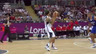

In [28]:
def recreate_movie(image_folder, new_name):
    fps=30
    image_files = [image_folder+'/'+img for img in os.listdir(image_folder) if img.endswith(".jpg")]
    image_files.sort()
    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
    clip.write_videofile(new_name + '.mp4')

In [29]:
recreate_movie('lebron_dunk1', 'recreated_movies/lebron_1')

Moviepy - Building video recreated_movies/lebron_1.mp4.
Moviepy - Writing video recreated_movies/lebron_1.mp4

Moviepy - Done !
Moviepy - video ready recreated_movies/lebron_1.mp4


In [38]:
len(data[0])

119

In [30]:
from torchvision import datasets, transforms

## YOUR CODE HERE ##
batch_size = 1
latent_dim = 20
transformations = transforms.ToTensor()
# mnist_train =  datasets.MNIST(loc_data, train=True, download=True, transform = transformations)
# mnist_test = datasets.MNIST(loc_data, train=False, download=True, transform = transformations)

In [53]:
images = data[0]
x_len = images[0].shape[0]
y_len = images[0].shape[1]
z_len = images[0].shape[2]
total_len = images[0].shape[0]*images[0].shape[1]*images[0].shape[2]

In [41]:
from torch.utils.data import DataLoader
train_loader = DataLoader(images,batch_size=batch_size,drop_last = True,shuffle=False)

In [54]:

class Encoder(nn.Module):
  def __init__(self, latent_dim):
    super(Encoder, self).__init__()
    ## YOUR CODE HERE ##
    self.lin1 = nn.Linear(total_len, total_len*3//4)
    self.lin2 = nn.Linear(total_len*3//4, total_len*1//4)
    self.lin3a = nn.Linear(total_len*1//4, latent_dim)
    self.lin3b = nn.Linear(total_len*1//4, latent_dim)
  
  def forward(self, x):
    ## YOUR CODE HERE ##\
    x = x.view(-1, total_len)
#     print(x)
    x = nn.functional.relu(self.lin1(x))
#     print(x)
    x = nn.functional.relu(self.lin2(x))
    # mu, log_var
    return self.lin3a(x), self.lin3b(x)

class Decoder(nn.Module):
  def __init__(self, latent_dim):
    super(Decoder, self).__init__()
    ## YOUR CODE HERE ##
    self.lin1 = nn.Linear(latent_dim, total_len*1//4)
    self.lin2 = nn.Linear(total_len*1//4, total_len*3//4)
    self.lin3 = nn.Linear(total_len*3//4, total_len)

  def forward(self,x):
    ## YOUR CODE HERE ##
    x = nn.functional.relu(self.lin1(x))
    x = nn.functional.relu(self.lin2(x))
    x = torch.sigmoid(self.lin3(x))
    return x.view(x_len, y_len, z_len)

In [55]:
from torch import exp, randn_like
def sample(mu, logvar):
  ## YOUR CODE HERE ##
    std_dev = exp(0.5*logvar)
    return randn_like(mu)*std_dev + mu

In [56]:
from scipy.stats import norm
def vae_loss(x, x_hat, mu, logvar):
  ## YOUR CODE HERE ##
  # MSE LOSS + KL DIVERGENCE 
    mse_loss = torch.nn.MSELoss(reduction='sum')
#     mse = torch.mean(torch.pow(x-x_hat, 2))
    kl = -0.5*torch.mean(1 + logvar - torch.pow(mu, 2) - torch.exp(logvar))
    return (mse_loss(x, x_hat) + kl)

In [57]:


## YOUR CODE HERE ##
encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)
params = list(encoder.parameters())+list(decoder.parameters())
optimizer = optim.Adam(params, lr=1e-3)

In [60]:
def train(encoder, decoder, train_loader, optimizer, num_epochs = 10):
    encoder.train()
    decoder.train()
    i=0
    for epoch in range(num_epochs):
        train_loss=0
        for idx, data in enumerate(train_loader):
            data = data.view(x_len, y_len, z_len)
#             print(data.shape)
            optimizer.zero_grad()
            mu, log_var = encoder(data)
            result = decoder(sample(mu, log_var))
#             print(result)
#             if i != 0:
#                 return
            loss = vae_loss(result, data, mu, log_var)
            i+=1
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if idx%50 == 0 :
                print("Epoch: " + str(epoch+1) + " Batch: " + str(idx+1)+"/"+str(len(train_loader.dataset)//batch_size) + " Loss: " + str(loss.item() / len(data)))
        print("Epoch: " + str(epoch+1) + " avg loss: " + str(train_loss / len(train_loader.dataset)))

In [ ]:
train(encoder, decoder, train_loader, optimizer, num_epochs = 10)

Epoch: 1 Batch: 1/119 Loss: 1317817770.6666667
Epoch: 1 Batch: 51/119 Loss: 972.1253255208334


In [294]:

Amu, Alog_var = encoder(images[0])
Aresult = decoder(sample(Amu, Alog_var))

In [213]:
for idx, data in enumerate(train_loader):
    data = data.view(-1, x_len, y_len)/255
    mu, log_var = encoder(data)
    result = decoder(sample(mu, log_var))
    break
#             print(result)
#             if i != 0:
#                 return
#     loss = vae_loss(result, data, mu, log_var)
#     i+=1
#     loss.backward()
#     train_loss += loss.item()
#     optimizer.step()

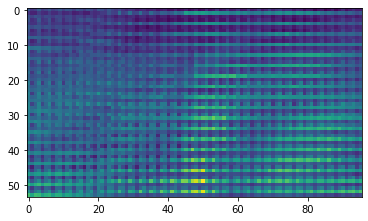

In [295]:
plt.imshow(Aresult.detach().numpy()[0])

In [296]:
Aresult.detach().numpy()[0]

array([[0.2591318 , 0.19090378, 0.20884179, ..., 0.17035276, 0.14299782,
        0.14497215],
       [0.18867424, 0.15483862, 0.15350024, ..., 0.2692045 , 0.23376402,
        0.26145387],
       [0.24430583, 0.21621224, 0.24926248, ..., 0.16624177, 0.13715088,
        0.15552469],
       ...,
       [0.28568104, 0.19070049, 0.29048282, ..., 0.3922836 , 0.2601436 ,
        0.33433163],
       [0.39923337, 0.25534746, 0.33532134, ..., 0.5430732 , 0.4874085 ,
        0.5355556 ],
       [0.52414197, 0.46041366, 0.5201867 , ..., 0.2533327 , 0.20952615,
        0.2326905 ]], dtype=float32)

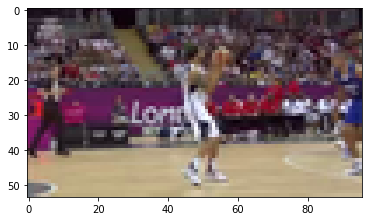

In [298]:
# images[0]/255
plt.imshow(images[0]/255)